<center><h3>XGBoost and SMOTE on Imbalanced Data</h3></center>
<center><font size=\"4\">Name: Jiahao Liu<br>Github: Julius-JiahaoLiu</font></center>

In [92]:
!pip install imblearn

In [5]:
import pandas as pd
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.svm import SVC

#### 1. Tree-Based Methods
(a) Download the APS Failure data. The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. The attributes are as follows: class, then anonymized operational data. The operational data have an identifier and a bin id, like "Identifier_Bin". In total there are 171 attributes, of which 7 are histogram variabels. Missing values are denoted by "na". All attributes are numeric except the class is "pos" or "neg".

In [26]:
# Read the training dataset
train_data = pd.read_csv('../data/aps_failure_training_set.csv', na_values='na')
test_data = pd.read_csv('../data/aps_failure_test_set.csv', na_values='na')
train_data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


(b) Data Preparation

This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea. (*In reality, when we have a model and we want to fill in missing values, we do not have access to training data, so we only use the statistics of test data to fill in the missing values*)

i. Research what types of techniques are usually used for dealing with data with missing values. (*They are called data imputation techniques*). Pick at least one of them and apply it to this data in the next steps (*You are welcome to test more than one method*).

**Answer:** When dealing with missing values in a dataset, there are several data imputation techniques we can use. Here are some common techniques:

1. Imputation with a Constant: Fill missing values with a constant value, like 0.0.

2. Mean/Median/Mode Imputation:
- Mean Imputation: Replace missing values with the mean of the column. Effective for continuous data.
- Median Imputation: Use the median value when data has outliers, as it is more robust.
- Mode Imputation: For categorical data, replacing missing values with the most frequent value (mode).

3. K-Nearest Neighbors (KNN) Imputation: This method uses the k-nearest neighbors algorithm to fill in missing values. It works by finding the k nearest data points with known values and averaging them.

4. Regression Imputation: Utilize regression models to predict and fill in missing values based on other attributes.

5. Multiple Imputation: An advanced method that involves creating multiple complete datasets by imputing missing values multiple times and combining results.

**I will use sklearn.impute to replace missing values by median.**

In [27]:
# Separate the features and the label
X_train = train_data.drop(columns='class')
y_train = train_data['class']
X_test = test_data.drop(columns='class')
y_test = test_data['class']
# Convert target variable from strings to numeric values (0 for 'neg', 1 for 'pos')
y_train = y_train.map({'neg': 0, 'pos': 1})
y_test = y_test.map({'neg': 0, 'pos': 1})
# Median Imputation
median_imputer = SimpleImputer(strategy='median')
X_train_median_imputed = median_imputer.fit_transform(X_train)
X_test_median_imputed = median_imputer.transform(X_test)
# Convert imputed arrays back to DataFrame for easier handling
X_train_median_imputed_df = pd.DataFrame(X_train_median_imputed, columns=X_train.columns)
X_test_median_imputed_df = pd.DataFrame(X_test_median_imputed, columns=X_test.columns)

ii. For each of the 170 features, calculate the coefficient of variation $CV = s/m$, where s is sample standard deviation and m is sample mean.

In [28]:
def calculate_cv(dataframe):
    # Calculate mean and standard deviation for each feature/column
    means = dataframe.mean()
    std_devs = dataframe.std()
    # Calculate Coefficient of Variation (CV)
    cv = std_devs / means
    return cv

# Calculate CV for the training dataset
train_cv = calculate_cv(X_train_median_imputed_df)
print("Coefficient of Variation for Training Data Features:")
print(train_cv)
# Calculate CV for the test dataset
test_cv = calculate_cv(X_test_median_imputed_df)
print("\nCoefficient of Variation for Test Data Features:")
print(test_cv)

Coefficient of Variation for Training Data Features:
aa_000      2.450938
ab_000     10.383494
ac_000      2.310241
ad_000    244.322816
ae_000     24.200137
             ...    
ee_007      5.012754
ee_008      3.259079
ee_009      5.691612
ef_000     49.366659
eg_000     42.481747
Length: 170, dtype: float64

Coefficient of Variation for Test Data Features:
aa_000     7.405254
ab_000     7.270936
ac_000     2.305849
ad_000     3.738220
ae_000    18.796107
            ...    
ee_007     4.643697
ee_008     3.743667
ee_009     6.264979
ef_000    53.225724
eg_000    60.545241
Length: 170, dtype: float64


iii. Plot a correlation matrix for your features using pandas or any other tool.

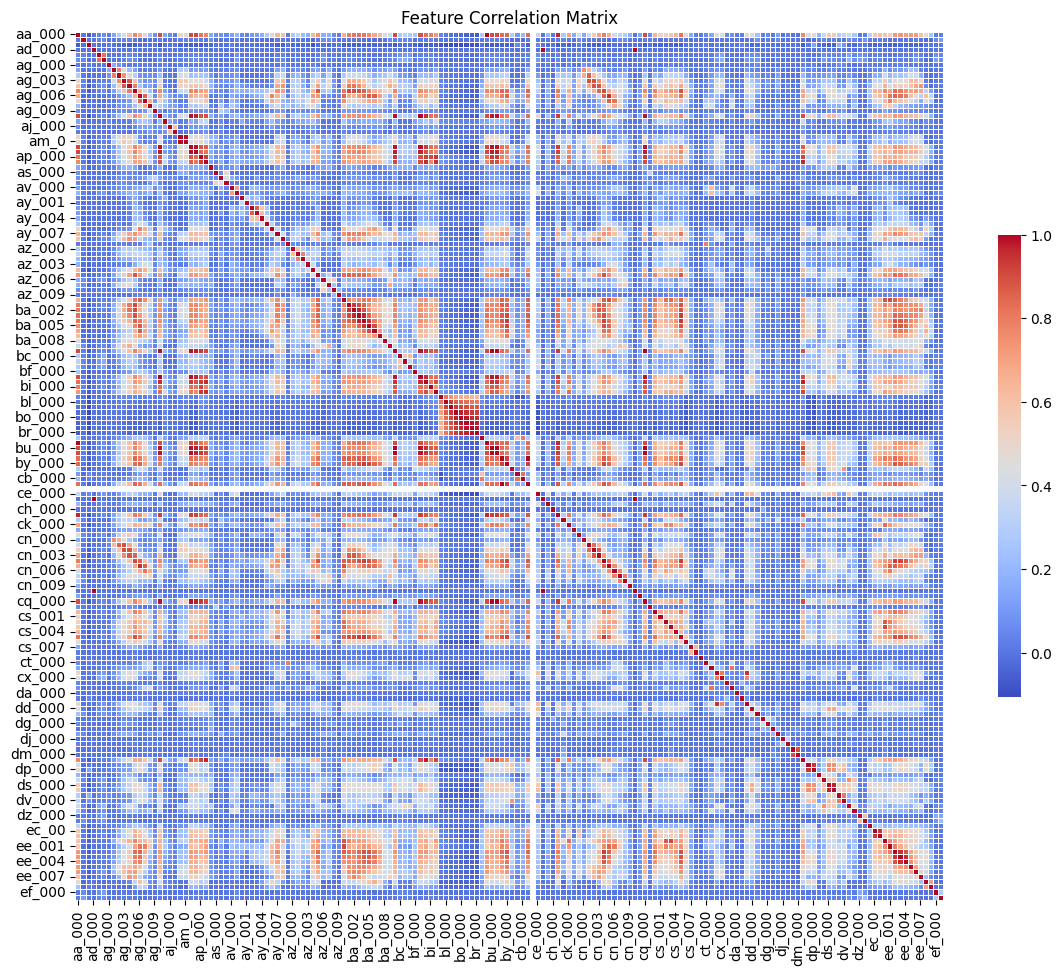

In [29]:
# Compute the correlation matrix using the imputed training DataFrame
correlation_matrix = X_train_median_imputed_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f', square=True, 
            linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Feature Correlation Matrix')
plt.show()

iv. Pick $\lfloor\sqrt{170}\rfloor$ features with highest $CV$, and make scatter plots and box plots for them, similar to those on p.129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

**Answer:** We can see from the scatter plots that only one feature dh_000 can divide "pos" and "neg" by a value boundary, and all the other picked features have no significance to class. And the *"significance"* of dh_000 might be caused by the outliers of feature data, because we can see obvious outliers from the box plots of the picked high CV features.

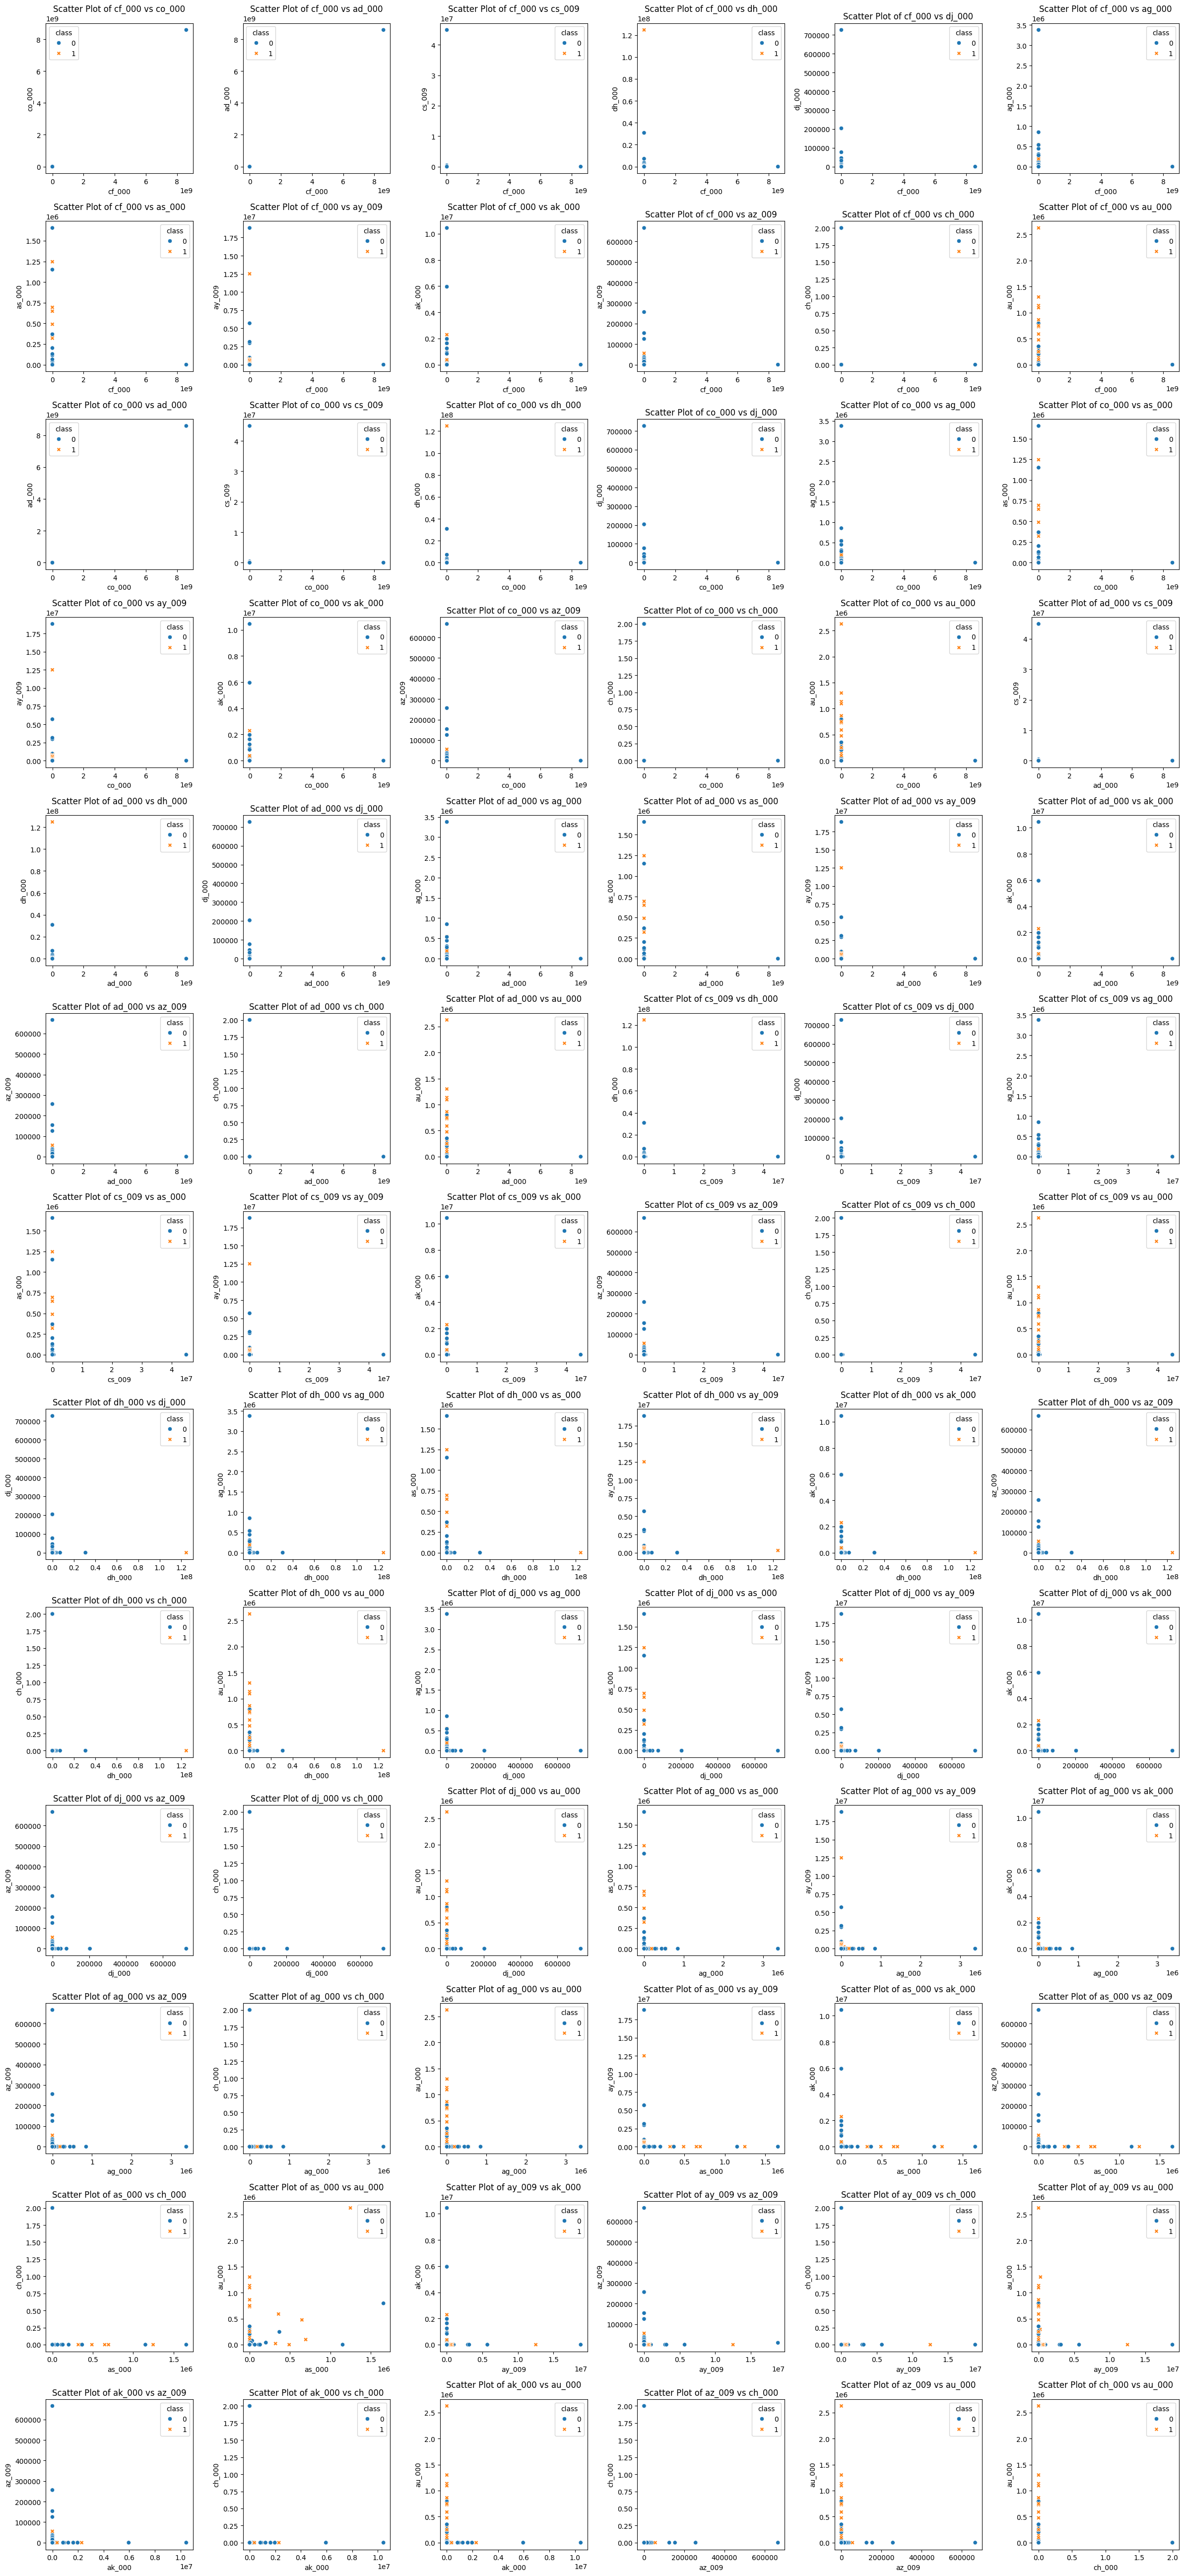

In [30]:
# Assuming X_train_median_imputed_df and y_train are available from previous steps
# Let's recombine imputed features and class for visualization
train_df_combined = pd.concat([X_train_median_imputed_df, y_train], axis=1)

# Count floor of square root of number of features
num_high_cv_features = int(np.floor(np.sqrt(170)))

# Get the features with the highest CV
top_cv_features = train_cv.nlargest(num_high_cv_features).index

def plot_feature_statistics(dataframe, features):
    # Generate all combinations of two features
    feature_combinations = list(combinations(features, 2))
    n_combinations = len(feature_combinations)
    
    # Set number of columns for the subplot grid
    num_rows = features.size
    num_cols = int(n_combinations / num_rows)
    
    # Create a large figure to accommodate all subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 4, num_rows * 4))
    axes = axes.flatten()  # Flatten to easily iterate over subplots

    for idx, (feature1, feature2) in enumerate(feature_combinations):
        ax = axes[idx]
        sns.scatterplot(data=dataframe, x=feature1, y=feature2, hue='class', style='class', ax=ax)
        ax.set_title(f'Scatter Plot of {feature1} vs {feature2}')
        ax.set_xlabel(feature1)
        ax.set_ylabel(feature2)
    
    # Remove any unused subplots
    for ax in axes[n_combinations:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

# Plot for training dataset
plot_feature_statistics(train_df_combined, top_cv_features)

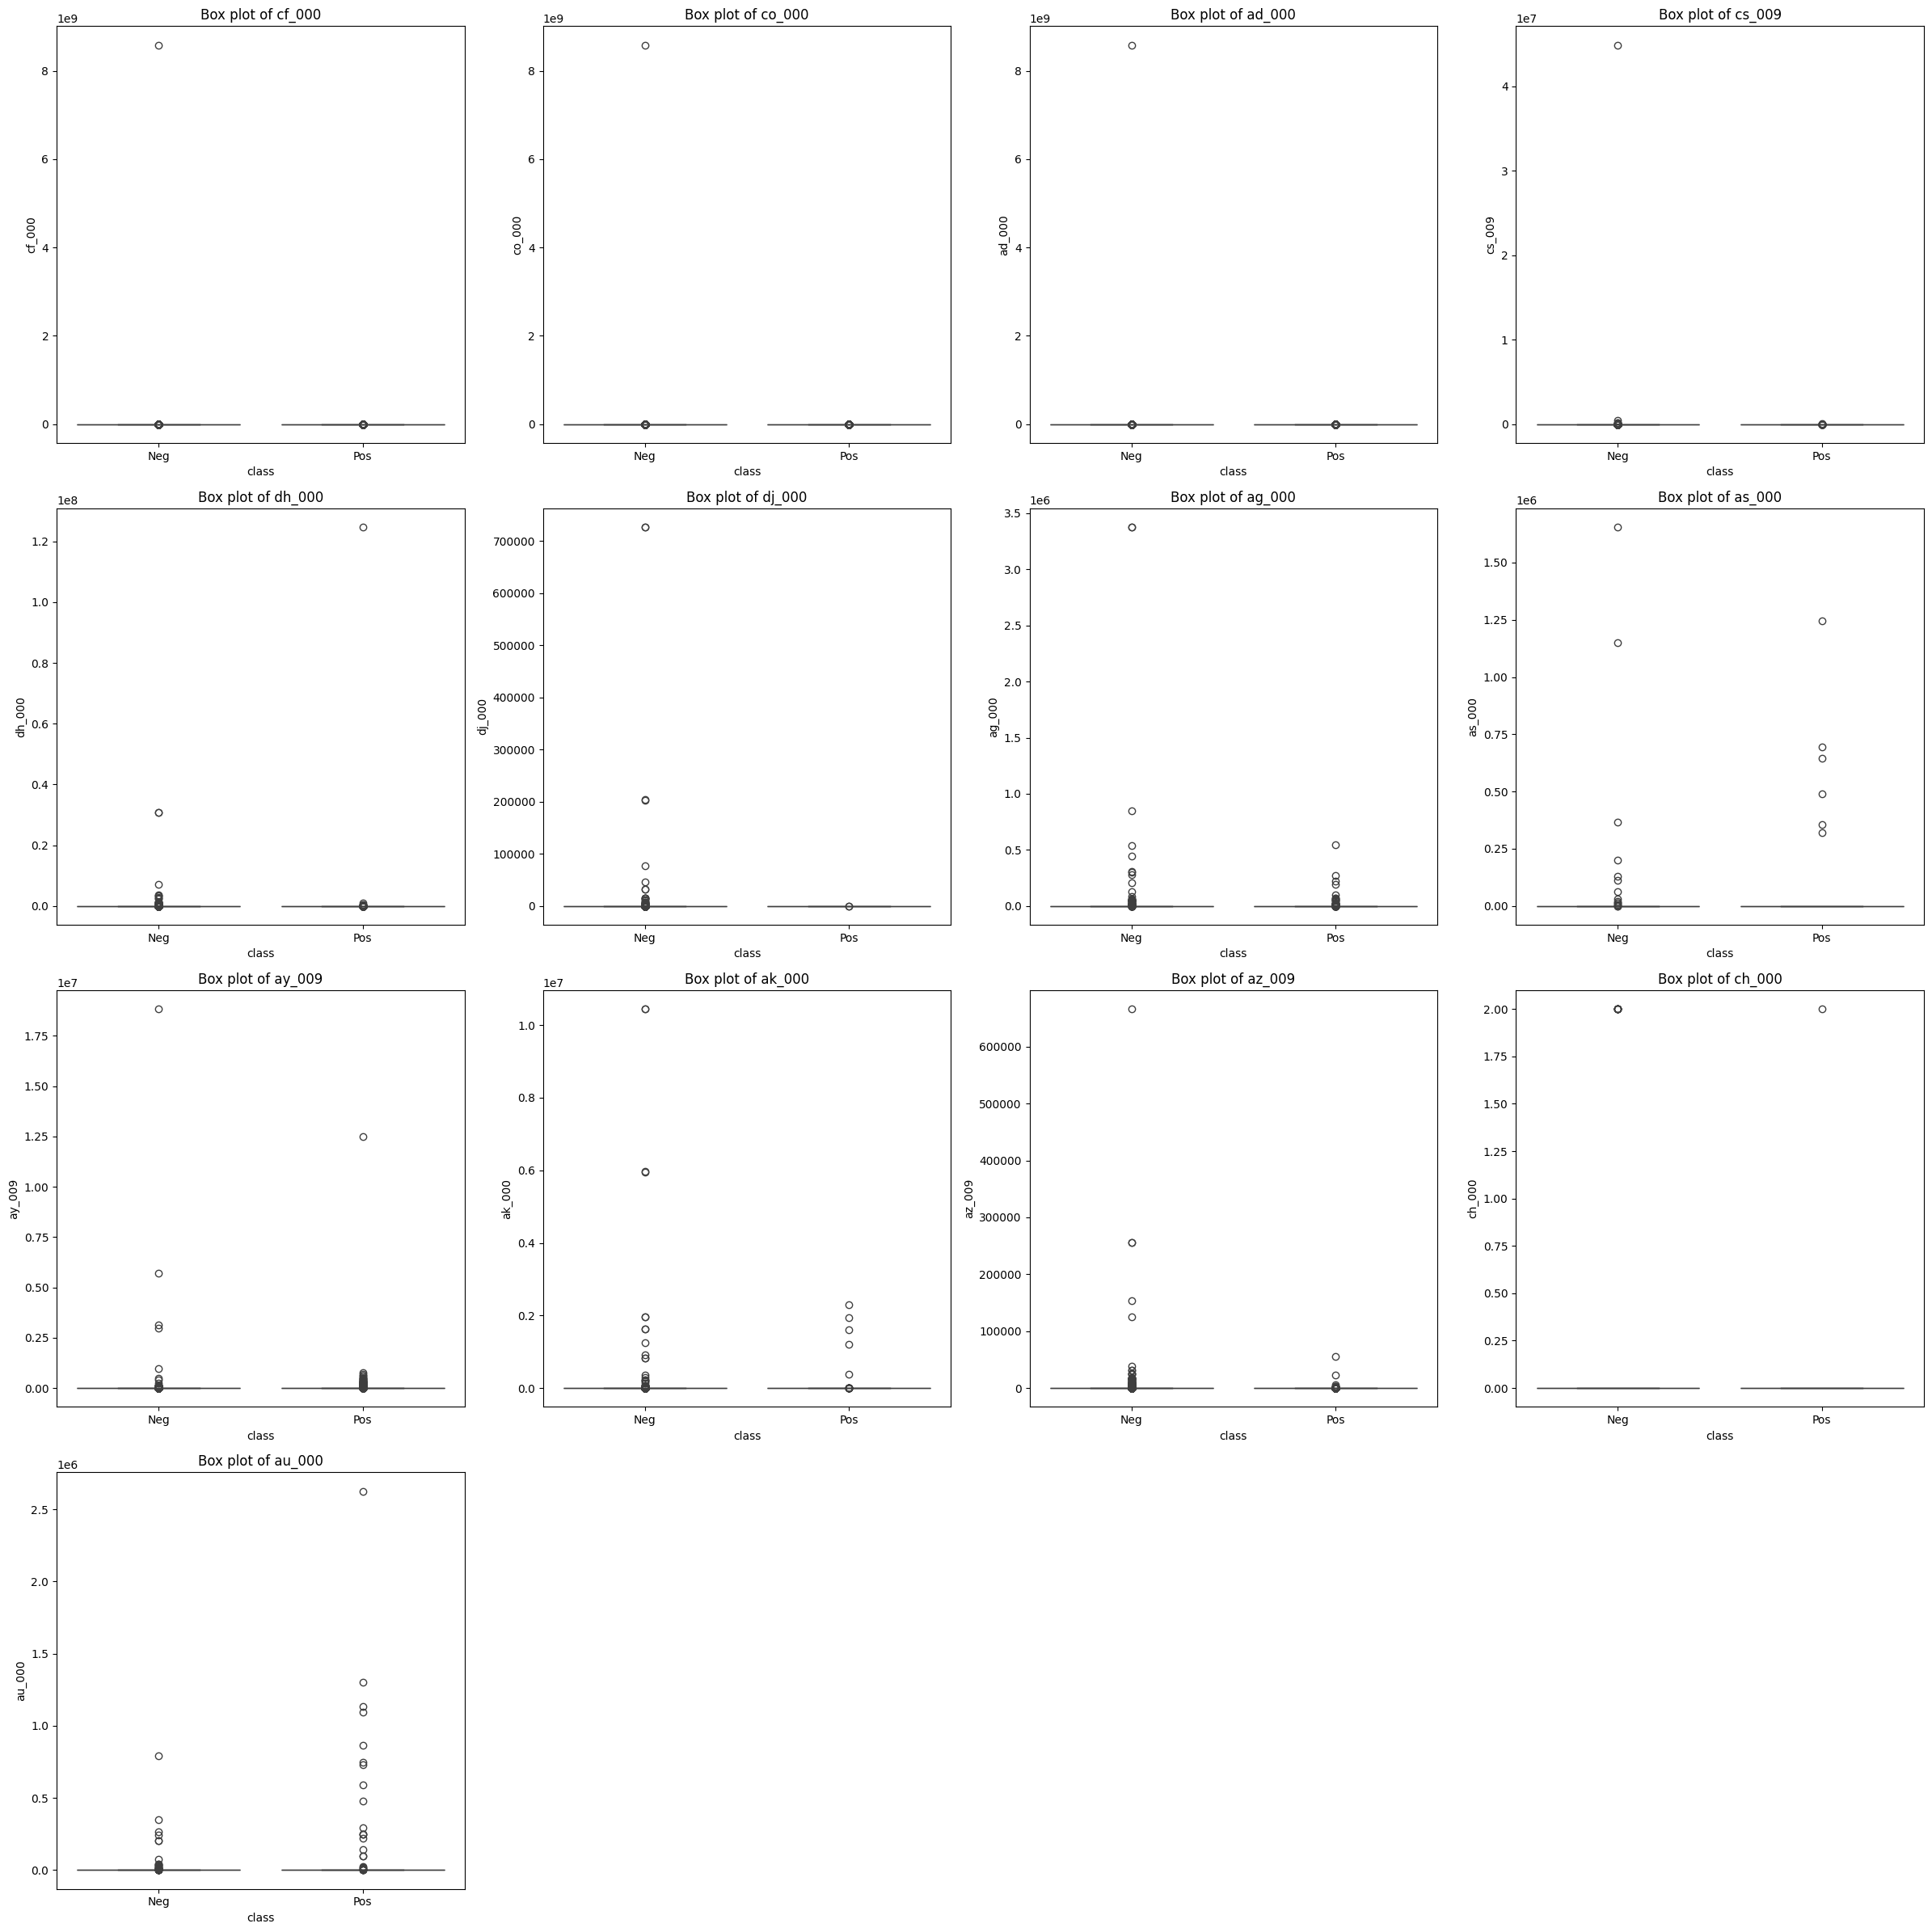

In [31]:
train_df_combined = pd.concat([X_train_median_imputed_df, y_train], axis=1)
num_rows = 4
num_cols = int(np.ceil(len(top_cv_features) / num_rows))
plt.figure(figsize=(6 * num_cols, 6 * num_rows))
# Create a plot for each feature
for i, feature in enumerate(top_cv_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x='class', y=feature, data=train_df_combined)
    plt.title(f'Box plot of {feature}')
    plt.xticks(ticks=[0, 1], labels=['Neg', 'Pos']) 

plt.tight_layout()
plt.show()

v. Determine the number of positive and negative data. Is this data set imbalanced?

**Answer:** we can see that pos class only make up 2% in both training and testing dateset, so the data set is severely imbalanced.

In [32]:
# Determine the number of positive and negative classes
positive_class_train = y_train[y_train == 1].count()
negative_class_train = y_train[y_train == 0].count()

print(f"Training Set - Positive Class: {positive_class_train}, Negative Class: {negative_class_train}")

positive_class_test = y_test[y_test == 1].count()
negative_class_test = y_test[y_test == 0].count()

print(f"Test Set - Positive Class: {positive_class_test}, Negative Class: {negative_class_test}")

# Check if the dataset is imbalanced
train_imbalance_ratio = positive_class_train / (positive_class_train + negative_class_train)
print(f"Training Set Imbalance Ratio: {train_imbalance_ratio:.2f}")

test_imbalance_ratio = positive_class_test / (positive_class_test + negative_class_test)
print(f"Test Set Imbalance Ratio: {test_imbalance_ratio:.2f}")

Training Set - Positive Class: 1000, Negative Class: 59000
Test Set - Positive Class: 375, Negative Class: 15625
Training Set Imbalance Ratio: 0.02
Test Set Imbalance Ratio: 0.02


(c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

**Answer:** OOB Error gives an internal error estimation based on the samples not used for training each tree. I see both OOB error and test error are 0.01, so this Random Forest model can generalize well to unseen data.

In [33]:
# Initialize Random Forest with OOB score
rf_model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)

# Train the model
rf_model.fit(X_train_median_imputed_df, y_train)

# Confusion matrix and metrics for train set
train_predictions = rf_model.predict(X_train_median_imputed_df)
conf_matrix_train = confusion_matrix(y_train, train_predictions)

# Confusion matrix and metrics for test set
test_predictions = rf_model.predict(X_test_median_imputed_df)
conf_matrix_test = confusion_matrix(y_test, test_predictions)

print("\nConfusion Matrix - Train Set:")
print(conf_matrix_train)
print("\nConfusion Matrix - Test Set:")
print(conf_matrix_test)


Confusion Matrix - Train Set:
[[59000     0]
 [    1   999]]

Confusion Matrix - Test Set:
[[15610    15]
 [  106   269]]


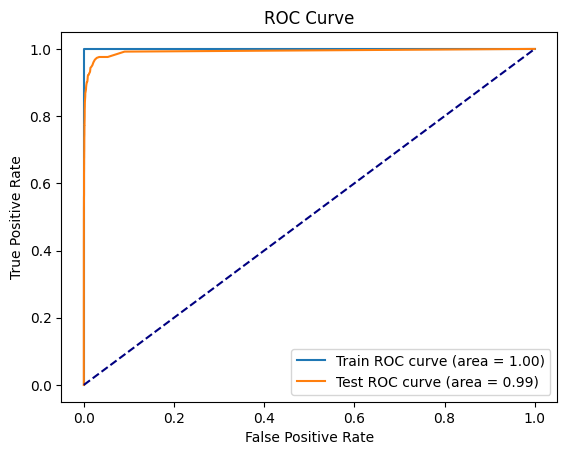


Train AUC: 1.00
Test AUC: 0.99

Train Misclassification Error: 0.0000167
Test Misclassification Error: 0.0075625

OOB Error: 0.01


In [37]:
# Calculate and plot ROC AUC
train_probs = rf_model.predict_proba(X_train_median_imputed_df)[:, 1]
test_probs = rf_model.predict_proba(X_test_median_imputed_df)[:, 1]

# ROC AUC for train
train_fpr, train_tpr, _ = roc_curve(y_train, train_probs, pos_label=1)
train_auc = auc(train_fpr, train_tpr)

# ROC AUC for test
test_fpr, test_tpr, _ = roc_curve(y_test, test_probs, pos_label=1)
test_auc = auc(test_fpr, test_tpr)

# Plot ROC Curves
plt.figure()
plt.plot(train_fpr, train_tpr, label=f'Train ROC curve (area = {train_auc:.2f})')
plt.plot(test_fpr, test_tpr, label=f'Test ROC curve (area = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"\nTrain AUC: {train_auc:.2f}")
print(f"Test AUC: {test_auc:.2f}")

# Misclassification error: fraction of incorrectly classified samples
train_misclassification = 1 - (conf_matrix_train.trace() / conf_matrix_train.sum())
test_misclassification = 1 - (conf_matrix_test.trace() / conf_matrix_test.sum())

print(f"\nTrain Misclassification Error: {train_misclassification:.7f}")
print(f"Test Misclassification Error: {test_misclassification:.7f}")

# Out Of Bag Error
oob_error = 1 - rf_model.oob_score_
print(f"\nOOB Error: {oob_error:.2f}")

(d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 1c. Compare the results with those of 1c.

**Answer:** To compensate for class imbalance, one common approach is to use the *class_weight* parameter of the *RandomForestClassifier* in scikit-learn. This parameter can be set to 'balanced', which automatically adjusts weights inversely proportional to class frequencies in the input data. 

From the Model Performance Metrics, i.e. confusion matrix, misclassification error, ROC curves, AUC and OOB Error, there is NO significant improvement of model's performance on unseen data.

In [38]:
# Initialize Random Forest with class weights
rf_model_balanced = RandomForestClassifier(n_estimators=100, 
                                           oob_score=True, 
                                           class_weight='balanced',
                                           random_state=42)

# Train the model
rf_model_balanced.fit(X_train_median_imputed_df, y_train)

# Predictions and evaluation for train set
train_predictions_balanced = rf_model_balanced.predict(X_train_median_imputed_df)
conf_matrix_train_balanced = confusion_matrix(y_train, train_predictions_balanced)

# Predictions and evaluation for test set
test_predictions_balanced = rf_model_balanced.predict(X_test_median_imputed_df)
conf_matrix_test_balanced = confusion_matrix(y_test, test_predictions_balanced)

print("\nConfusion Matrix - Train Set (Balanced):")
print(conf_matrix_train_balanced)
print("\nConfusion Matrix - Test Set (Balanced):")
print(conf_matrix_test_balanced)


Confusion Matrix - Train Set (Balanced):
[[59000     0]
 [    1   999]]

Confusion Matrix - Test Set (Balanced):
[[15611    14]
 [  160   215]]


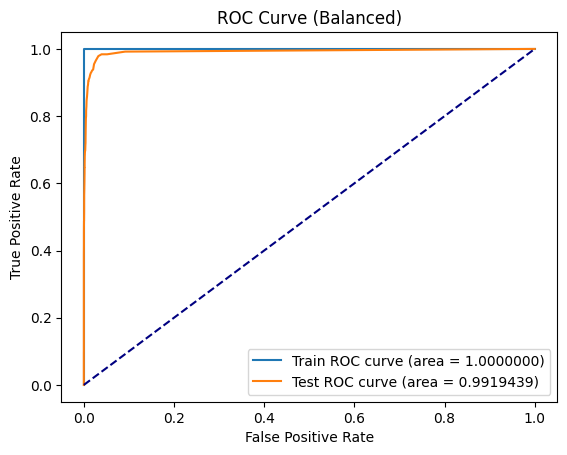


Train AUC (Balanced): 1.00
Test AUC (Balanced): 0.99

Train Misclassification Error (Balanced): 0.00
Test Misclassification Error (Balanced): 0.01

OOB Error (Balanced): 0.01


In [39]:
# Calculate and plot ROC AUC
train_probs_balanced = rf_model_balanced.predict_proba(X_train_median_imputed_df)[:, 1]
test_probs_balanced = rf_model_balanced.predict_proba(X_test_median_imputed_df)[:, 1]

# ROC AUC for train
train_fpr_balanced, train_tpr_balanced, _ = roc_curve(y_train, train_probs_balanced, pos_label=1)
train_auc_balanced = auc(train_fpr_balanced, train_tpr_balanced)

# ROC AUC for test
test_fpr_balanced, test_tpr_balanced, _ = roc_curve(y_test, test_probs_balanced, pos_label=1)
test_auc_balanced = auc(test_fpr_balanced, test_tpr_balanced)

# Plot ROC Curves
plt.figure()
plt.plot(train_fpr_balanced, train_tpr_balanced, label=f'Train ROC curve (area = {train_auc_balanced:.7f})')
plt.plot(test_fpr_balanced, test_tpr_balanced, label=f'Test ROC curve (area = {test_auc_balanced:.7f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Balanced)')
plt.legend(loc="lower right")
plt.show()
print(f"\nTrain AUC (Balanced): {train_auc_balanced:.2f}")
print(f"Test AUC (Balanced): {test_auc_balanced:.2f}")

# Misclassification error: fraction of incorrectly classified samples
train_misclassification_balanced = 1 - (conf_matrix_train_balanced.trace() / conf_matrix_train_balanced.sum())
test_misclassification_balanced = 1 - (conf_matrix_test_balanced.trace() / conf_matrix_test_balanced.sum())

print(f"\nTrain Misclassification Error (Balanced): {train_misclassification_balanced:.2f}")
print(f"Test Misclassification Error (Balanced): {test_misclassification_balanced:.2f}")
# Out Of Bag Error
oob_error_balanced = 1 - rf_model_balanced.oob_score_
print(f"\nOOB Error (Balanced): {oob_error_balanced:.2f}")


(e) XGBoost and Model Trees.

In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used
to determine the split of that node (i.e. instead of using $X_j > s$ as the dsecision rule, one has $\sum_j \beta_j X_j > s$ as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node.

One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can use L1-penalized logistic regression at each node. You can use XGBoos to fit the model tree. Determine $\alpha$ (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

In [40]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

param_grid = {
    'alpha': [0, 0.1, 1, 10],  # I just try these 4 values due to limit of computation resources
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200]
}

skf = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='roc_auc', cv=skf, verbose=1)
grid_search.fit(X_train_median_imputed_df, y_train)

# Best estimator
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'alpha': 10, 'max_depth': 4, 'n_estimators': 100}


Train Confusion Matrix:
 [[58973    27]
 [  143   857]]
Test Confusion Matrix:
 [[15608    17]
 [   94   281]]
Train AUC: 0.9973925254237288
Test AUC: 0.996197888


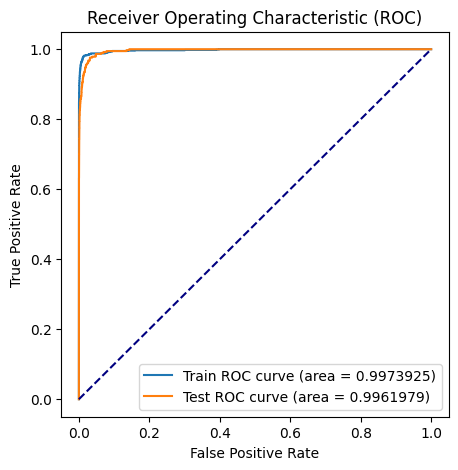

In [41]:
# Train predictions
y_train_pred = best_model.predict(X_train_median_imputed_df)
y_train_proba = best_model.predict_proba(X_train_median_imputed_df)[:, 1]

# Test predictions
y_test_pred = best_model.predict(X_test_median_imputed_df)
y_test_proba = best_model.predict_proba(X_test_median_imputed_df)[:, 1]

# Confusion Matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
print("Train Confusion Matrix:\n", cm_train)
print("Test Confusion Matrix:\n", cm_test)

# ROC and AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)
print("Train AUC:", roc_auc_train)
print("Test AUC:", roc_auc_test)

# ROC Curve plotting
plt.figure(figsize=(5, 5))
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (area = {roc_auc_train:.7f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {roc_auc_test:.7f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

(f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance. 

*If you did not start doing this homework on time, downsample the common class to 6,000 so that you have 12,000 data points after applying SMOTE. Remember that the purpose of this homework is to apply SMOTE to the whole training set, not the downsampled dataset*

Train XGBosst with L1-penalized logistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

**Answer:** I will use the imbalanced-learn library, using efficient algorithms under the hood which can handle moderately large datasets more swiftly for performance.

Based on the comparision of Comfusion Matrix, ROC and AUC, we can see that model trained with upsampled training dataset is kind of overfitting, because there is an increase in train AUC from 0.9974 to 0.9999 but a decrease in test AUC from 0.99620 to 0.99358. 

This can be explained by the fact that this is similar imbalance in test dataset as in the train dataset, so it's might not a good idea to SMOTE data.

In [42]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_median_imputed_df, y_train)
print(f"Original class distribution: {Counter(y_train)}")
print(f"Resampled class distribution: {Counter(y_train_resampled)}")

Original class distribution: Counter({0: 59000, 1: 1000})
Resampled class distribution: Counter({0: 59000, 1: 59000})


In [43]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

param_grid = {
    'alpha': [0, 0.1, 1, 10],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200]
}

skf = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='roc_auc', cv=skf, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model_resampled = grid_search.best_estimator_
print("Best parameters from CV:", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters from CV: {'alpha': 0, 'max_depth': 5, 'n_estimators': 200}


Train Confusion Matrix:
 [[59000     0]
 [    1   999]]
Test Confusion Matrix:
 [[15580    45]
 [   68   307]]
Train AUC: 0.9999999830508475
Test AUC: 0.9935817386666667


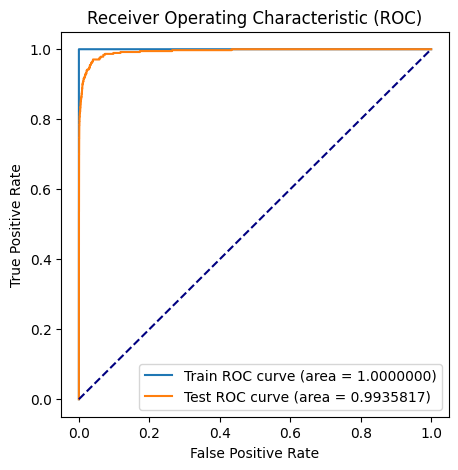

In [44]:
# Train predictions
y_train_pred = best_model_resampled.predict(X_train_median_imputed_df)
y_train_proba = best_model_resampled.predict_proba(X_train_median_imputed_df)[:, 1]

# Test predictions
y_test_pred = best_model_resampled.predict(X_test_median_imputed_df)
y_test_proba = best_model_resampled.predict_proba(X_test_median_imputed_df)[:, 1]

# Confusion Matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
print("Train Confusion Matrix:\n", cm_train)
print("Test Confusion Matrix:\n", cm_test)

# ROC and AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)
print("Train AUC:", roc_auc_train)
print("Test AUC:", roc_auc_test)

# Plot ROC Curve
plt.figure(figsize=(5, 5))
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (area = {roc_auc_train:.7f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {roc_auc_test:.7f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### 2. ISLR 6.6.3
Suppose we estimate the regression coefficients in a linear regression model by minimizing 
$$\sum_{i=1}^n(y_i - \beta_0 - \sum_{j=1}^p\beta_j x_{ij})^2\quad subject\ to \sum_{j=1}^p|\beta_j| \leq s$$
for a particular value of s. For parts (a) through (e), indicate which of i. through v. is correct. Justify your answer.

(a) As we increase s from 0, the training RSS will:

i. Increase initially, and then eventually start decreasing in an inverted U shape.

ii. Decrease initially, and then eventually start increasing in a U shape.

iii. Steadily increase.

iv. Steadily decrease.

v. Remain constant.

**Answer:** As we increase s from 0, the training RSS will: iv. Steadily decrease.

Justification: The problem describes performing a Lasso regression, where the regression coefficients are estimated by minimizing the residual sum of squares subject to a constraint on the sum of the absolute values of the coefficients. The parameter (s) controls the amount of regularization:
- When (s = 0), the constraint forces all coefficients to be zero (except potentially the intercept $\beta_0$), resulting in a high training RSS because the model is essentially predicting $\bar{y}$
- As (s) increases, more coefficients are allowed to be non-zero, leading to a better fit to the training data and hence a reduction in the training RSS.
- Provided there are enough coefficients to fit the data well, the training RSS will generally decrease as constraints are relaxed and more parameters are allowed to contribute to the model fitting.

(b) Repeat (a) for test RSS.

**Answer:** As we increase (s) from 0, the test RSS will: ii. Decrease initially, and then eventually start increasing in a U shape.

Justification: 
- When (s) is very small, the model is heavily regularized, likely underfitting the data, leading to a high test RSS because it cannot adequately capture the underlying patterns in the data. 
- As (s) increases, the model can fit the data better by including more features, often leading to a decrease in test RSS initially because the model transitions from underfitting to a well-balanced fit.
- However, if (s) continues to increase beyond a certain point, the model may begin to overfit the training data, which means it captures noise rather than just the underlying pattern. This overfitting leads to an increase in test RSS as the model's performance on unseen data deteriorates. This behavior typically creates a U-shaped curve, with an initial decrease in test RSS followed by an increase as overfitting begins to occur. This reflects the classical bias-variance tradeoff.

(c) Repeat (a) for variance.

**Answer:** As we increase (s) from 0, the variance will: iii. Steadily increase.

Justification:
- Variance in the context of model predictions refers to how much the model's predictions would change if we used a different training dataset. A higher variance indicates that predictions are more sensitive to variations in the training data.
- When (s) is very small, the model is heavily regularized, potentially leading to most regression coefficients being zero and reducing variability between different datasets. Thus, variance is low.
- As (s) increases, more coefficients can become non-zero, allowing the model to fit details of the training data. This implies that predictions may change significantly if the training data changes, increasing variance. Therefore, as (s) increases and more features are considered in the model, the model's variance typically increases because it becomes more sensitive to the particular training data it was fit on.

(d) Repeat (a) for (squared) bias.

**Answer:** As we increase (s) from 0, the (squared) bias will: iv. Steadily decrease.

Justification:

- Bias refers to the error introduced by approximating a real-world problem, which may be complex, by a simplified model. A high bias indicates that the model assumptions are too strong or too simplified, causing the model to miss relevant relationships between features and the target output.
- When (s) is very small, the model is heavily regularized, leading to a high level of simplification (underfitting), and thus, the model has high bias because it may not capture the true underlying data structure.
- As we increase (s), the model becomes more flexible because it can include more features with non-zero coefficients. This flexibility allows the model to better capture the underlying data structure, thus reducing bias. Thus, increasing (s) typically results in a reduction of bias as long as the model avoids overfitting, leading to a steadier decrease in bias as the model becomes more capable of representing the true relationships in the data.

(e) Repeat (a) for the irreducible error.

**Answer:** As we increase (s) from 0, the irreducible error will: v. Remain constant.

Justification:

- The irreducible error represents the error that is inherent to the problem itself, due to *variability in the data that cannot be captured by any model*. This error comes from various sources like measurement errors, unmeasured variables, or inherent unpredictability.

- This type of error is not influenced by the complexity or flexibility of the model. Therefore, changes in (s), which affect model complexity and fitting capacity, will not have any impact on the irreducible error. 

- As a result, the irreducible error remains constant regardless of the value of (s) because it is a characteristic of the data generation process itself and not of the model.

#### 3. ISLR 6.6.5
It is well-known that ridge regression tends to give similar coefficient values to correlated variables, whereas the lasso may give quite different coefficient values to correlated variables. We will now explore this property in a very simple setting.

Suppose that $n = 2, p = 2, x_{11} = x_{12}, x_{21} = x_{22}$. Furthermore, suppose that $y_1 + y_2 =0$ and $x_{11} + x_{21} = 0$ and $x_{12} + x_{22} = 0$, so that the estimate for the intercept in a least squares, ridge regression, or lasso model is zero: $\hat{\beta}_0 = 0$

(a) Write out the ridge regression optimization problem in this setting.

**Answer:** Given that $\hat{\beta}_0 = 0$, the ridge regression optimization problem aims to minimize the following cost function:

$$ \text{Min} \quad \sum_{i=1}^{n} \left( y_i - \sum_{j=1}^{p} x_{ij} \beta_j \right)^2 + \lambda \sum_{j=1}^{p} \beta_j^2 $$

Given our scenario with ( n = 2 ) and ( p = 2 ), the optimization becomes:

$$ \text{Min} \quad \left( y_1 - x_{11}\beta_1 - x_{12}\beta_2 \right)^2 + \left( y_2 - x_{21}\beta_1 - x_{22}\beta_2 \right)^2 + \lambda (\beta_1^2 + \beta_2^2) $$

Since $x_{11} = x_{12} = - x_{21} = - x_{22}$ and $y_1 = - y_2$, the ridge regression problem reduces to:

$$ \text{Min} \quad 2y_1^2 + (2x_{11}^2 + \lambda)(\beta_1^2 + \beta_2^2) + 4x_{11}^2\beta_1\beta_2 $$

(b) Argue that in this setting, the ridge coefficient estimates satisfy $\hat{\beta_1} = \hat{\beta_2}$.

**Answer:** To find the minimizer of this loss function, differentiate with respect to $\beta_1$ and $\beta_2$, and then set these derivatives to 0:

Differentiate ( L ) with respect to $\beta_1$: $ \frac{\partial L}{\partial \beta_1} = 2(2x_{11}^2 + \lambda)\beta_1 + 4x_{11}^2\beta_2 = 0$

Differentiate ( L ) with respect to $\beta_2$: $ \frac{\partial L}{\partial \beta_2} = 2(2x_{11}^2 + \lambda)\beta_2 + 4x_{11}^2\beta_1 = 0$

Make a difference for the two equations, we can get $\lambda(\beta_1 - \beta_2) = 0$, so $\hat{\beta_1} = \hat{\beta_2}$.

(c) Write out the lasso optimization problem in this setting.

**Answer:** Given $\hat{\beta}_0 = 0$, the lasso regression aims to minimize the following cost function, which includes an ( L1 ) penalty:

$$ \text{Min} \quad \sum_{i=1}^{n} \left( y_i - \sum_{j=1}^{p} x_{ij} \beta_j \right)^2 + \lambda \sum_{j=1}^{p} |\beta_j| $$

Given ( n = 2 ) and ( p = 2 ) in the context of the problem, the lasso problem is:

$$ \text{Min} \quad \left( y_1 - x_{11}\beta_1 - x_{12}\beta_2 \right)^2 + \left( y_2 - x_{21}\beta_1 - x_{22}\beta_2 \right)^2 + \lambda (|\beta_1| + |\beta_2|) $$

Since $x_{11} = x_{12} = - x_{21} = - x_{22}$ and $y_1 = - y_2$, this simplifies to:

$$ \text{Min} \quad 2y_1^2 + 2x_{11}^2(\beta_1 + \beta_2)^2 + \lambda (|\beta_1| + |\beta_2|)$$

(d) Argue that in this setting, the lasso coefficients $\hat{\beta}_1$ and $\hat{\beta}_2$ are not unique, in other words, there are many possible solutions to the optimization problem in (c). Describe these solutions.

**Answer:** we can see the second term $2x_{11}^2(\beta_1 + \beta_2)^2$ is minimized when $\beta_1 + \beta_2 = 0$, since any deviation from this shorthand expression contributes to the loss. Now the lasso cost function becomes $2y_1^2 + 2\lambda|\beta_1|$, so the coefficients are not unique and lie on the line $\beta_1 + \beta_2 = 0$.

#### 4. ISLR 8.4.5
Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X, produce 10 estimates of P(Class is Red|X):

0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75

There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?


**Answer:** 
1. Majority Vote Approach: For the majority vote, each of the 10 trees makes a binary decision: classify as Red if the estimated probability ( $P(\text{Class is Red} \mid X) ) > 0.5$, otherwise classify as Green. Let's evaluate each estimate: <br>
0.1 -> Green 0.15 -> Green 0.2 -> Green 0.2 -> Green 0.55 -> Red 0.6 -> Red 0.6 -> Red 0.65 -> Red 0.7 -> Red 0.75 -> Red <br>
Counting the votes:<br>
Red votes: 6<br> 
Green votes: 4

Result: Since the majority of the trees vote for Red (6 out of 10), the final classification under the majority vote approach is Red.

2. Average Probability Approach:
In this approach, we calculate the average of the estimated probabilities and classify as Red if the average probability is greater than 0.5<br>
$$ \text{Average Probability} = \frac{0.1 + 0.15 + 0.2 + 0.2 + 0.55 + 0.6 + 0.6 + 0.65 + 0.7 + 0.75}{10} = \frac{4.5}{10} = 0.45 $$ 
Result: Since the average probability (0.45) is less than 0.5, the final classification under the average probability approach is Green.

#### 5. ISLR 9.7.3
Here we explore the maximal margin classifier on a toy data set.

(a) We are given n = 7 observations in p = 2 dimensions. For each observation, there is an associated class label.
<center>

| Obs.  | $X_1$ | $X_2$ | $Y$ |
| :---: | :---: | :---: | :---: |
| 1 | 3 | 4 | Red |
| 2 | 2 | 2 | Red | 
| 3 | 4 | 4 | Red |
| 4 | 1 | 4 | Red |
| 5 | 2 | 1 | Blue |
| 6 | 4 | 3 | Blue |
| 7 | 4 | 1 | Blue |

</center>
Sketch the observations.


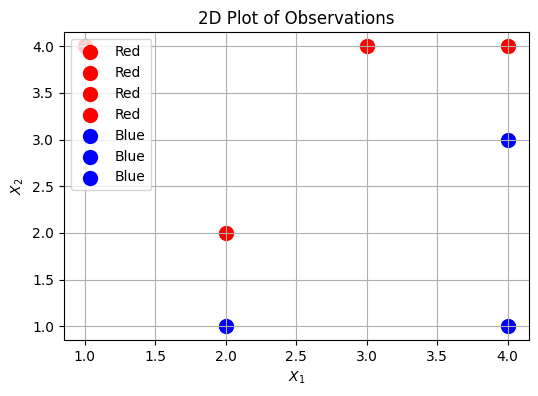

In [45]:
# Data points
X = np.array([
    [3, 4],
    [2, 2],
    [4, 4],
    [1, 4],
    [2, 1],
    [4, 3],
    [4, 1]
])

# Labels ('Red' -> 1, 'Blue' -> -1)
y = np.array([1, 1, 1, 1, -1, -1, -1])

# Plot the data
plt.figure(figsize=(6, 4))
for i, color in zip(range(len(y)), ['red']*4 + ['blue']*3):
    plt.scatter(X[i, 0], X[i, 1], c=color, s=100, label='Red' if y[i] == 1 else 'Blue')

plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.title("2D Plot of Observations")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

(b) Sketch the optimal separating hyperplane, and provide the equation for this hyperplane in the form of $\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p = 0$.

Equation: 1.00 + -2.00 * X1 + 2.00 * X2 = 0


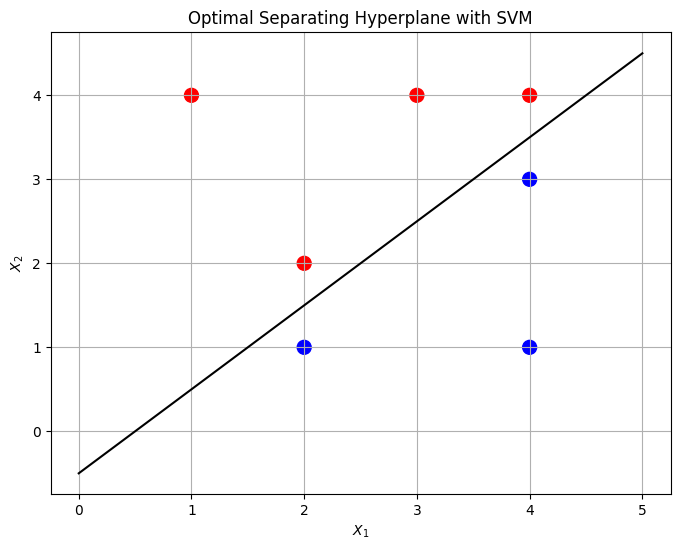

In [46]:
# Create a linear SVM classifier
svc = SVC(kernel='linear', C=1e10)  # Large C for hard margin

# Fit the model
svc.fit(X, y)

# Retrieve the coefficients
coef = svc.coef_.flatten()
intercept = svc.intercept_

# Define the equation of the hyperplane: eta_0 + eta_1 * X1 + eta_2 * X2 = 0
print(f"Equation: {intercept[0]:.2f} + {coef[0]:.2f} * X1 + {coef[1]:.2f} * X2 = 0")

# Plot the data and the decision boundary
plt.figure(figsize=(8, 6))
colors = ['red' if label == 1 else 'blue' for label in y]
plt.scatter(X[:, 0], X[:, 1], c=colors, s=100)

# Plot the decision boundary
# The decision boundary is line: w0 + w1 * X1 + w2 * X2 = 0
xx = np.linspace(0, 5, 100)
yy = -(coef[0] * xx + intercept[0]) / coef[1]
plt.plot(xx, yy, 'k-')

plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.title("Optimal Separating Hyperplane with SVM")
plt.grid(True)
plt.show()

(c) Describe the classification rule for the maximal margin classifier. It should be something along the lines of *Classify to Red if $\beta_0 + \beta_1X_1 + \beta_2X_2 > 0$, and classify to Blue otherwise.* Provide the values for $\beta_0, \beta_1, \beta_2$.

**Answer:** Using the model's coefficients, we can define the classification rule based on the decision function:

Classify to Red if $1.00 - 2.00X_1 + 2.00 X_2 > 0 $, and Blue other wise.

In [47]:
def classify(x1, x2):
    decision_value = coef[0] * x1 + coef[1] * x2 + intercept[0]
    if decision_value > 0:
        return "Red"
    else:
        return "Blue"

# Test the classification rule
print(f"Classify point (3,4): {classify(3, 4)}")
print(f"Classify point (2,1): {classify(2, 1)}")

Classify point (3,4): Red
Classify point (2,1): Blue


(d) On your sketch, indicate the margin for the maximal margin hyperplane.

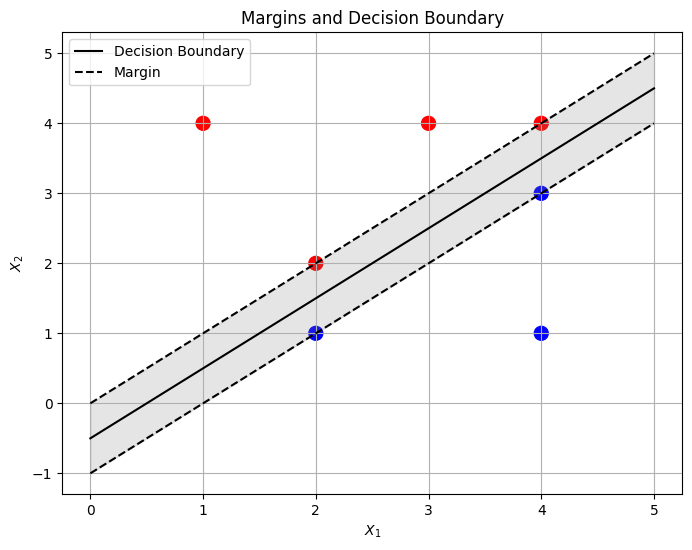

In [48]:
# Create a mesh to plot
xx = np.linspace(0, 5, 100)

# Calculate hyperplane
yy_decision = -(coef[0] * xx + intercept[0]) / coef[1]

# Calculate margin lines (distance equal to support vector distance)
margin = 1 / np.sqrt(np.sum(svc.coef_ ** 2))
yy_margin_up = yy_decision + np.sqrt(1 + (coef[0] / coef[1]) ** 2) * margin
yy_margin_down = yy_decision - np.sqrt(1 + (coef[0] / coef[1]) ** 2) * margin

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=colors, s=100)

# Plot decision boundary and margins
plt.plot(xx, yy_decision, 'k-', label='Decision Boundary')
plt.plot(xx, yy_margin_up, 'k--', label='Margin')
plt.plot(xx, yy_margin_down, 'k--')

plt.fill_between(xx, yy_margin_up, yy_margin_down, color='gray', alpha=0.2)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.title("Margins and Decision Boundary")
plt.grid(True)
plt.legend()
plt.show()

(e) Indicate the support vectors for the maximal margin classifier.

**Answer:** Support Vectors are highlighted by special markers in the following figure

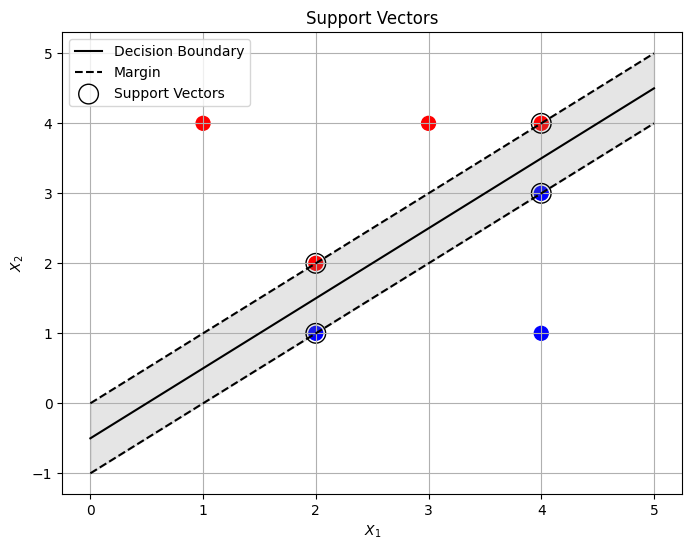

In [49]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=colors, s=100)

# Plot decision boundary and margins
plt.plot(xx, yy_decision, 'k-', label='Decision Boundary')
plt.plot(xx, yy_margin_up, 'k--', label='Margin')
plt.plot(xx, yy_margin_down, 'k--')

plt.fill_between(xx, yy_margin_up, yy_margin_down, color='gray', alpha=0.2)

# Highlight support vectors
support_vectors = svc.support_vectors_
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=200, facecolors='none', edgecolor='k', label='Support Vectors')

plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.title("Support Vectors")
plt.grid(True)
plt.legend()
plt.show()

(f) Argue that a slight movement of the seventh observation, i.e. (4, 1, Blue), would not affect the maximal margin hyperplane.

**Answer:** Observation (4, 1, Blue) that lies strictly on the correct side of the margin does not affect the support vector classifier, because only observations that either lie on the margin or that violate the margin will affect the hyperplane and hence the classifier obtained!

(g) Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.

**Answer:** Equation for non-optimal hyperplane: $ 1.1X_1 - X_2 - 1.0 = 0 $

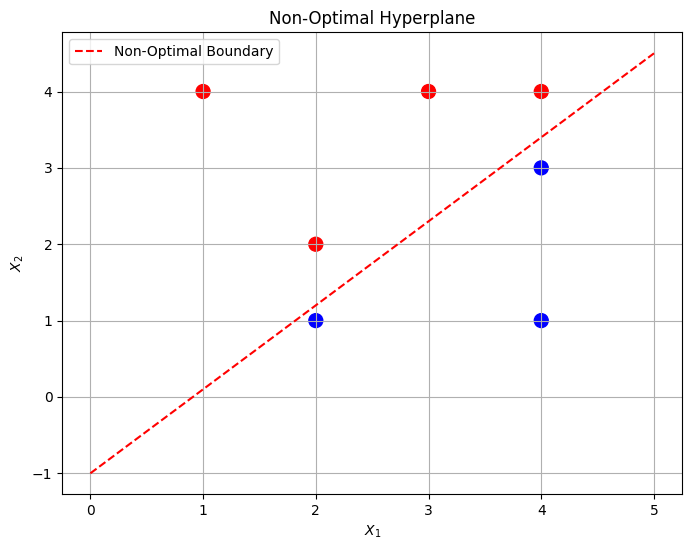

In [50]:
# Manually plot a non-optimal hyperplane
yy_non_optimal = 1.1 * xx - 1  # arbitrary choice for a non-optimal line

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=colors, s=100)

# Plot non-optimal decision boundary
plt.plot(xx, yy_non_optimal, 'r--', label='Non-Optimal Boundary')

plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.title("Non-Optimal Hyperplane")
plt.grid(True)
plt.legend()
plt.show()

(h) Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.

**Answer:** By adding the new observation at (3, 3.5) with a Blue class, the dataset becomes non-linearly separable.

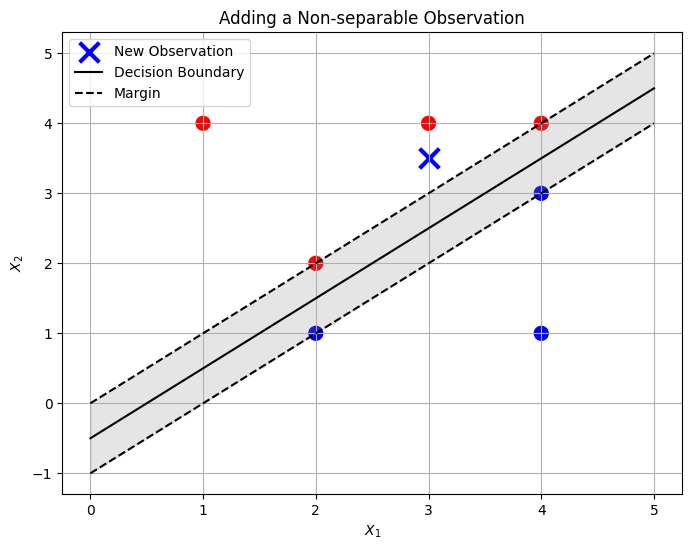

In [51]:
# New observation that makes the classes non-separable
new_observation = np.array([[3, 3.5]])  # Placed in Red's space, with Blue's label
new_label = -1  # Assigning Blue label

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=colors, s=100)
plt.scatter(new_observation[:, 0], new_observation[:, 1], color='blue', marker='x', s=200, linewidths=3, label='New Observation')

# Plot decision boundary and margins
plt.plot(xx, yy_decision, 'k-', label='Decision Boundary')
plt.plot(xx, yy_margin_up, 'k--', label='Margin')
plt.plot(xx, yy_margin_down, 'k--')

plt.fill_between(xx, yy_margin_up, yy_margin_down, color='gray', alpha=0.2)

plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.title("Adding a Non-separable Observation")
plt.grid(True)
plt.legend()
plt.show()